# 1

In [268]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import Birch, KMeans, AgglomerativeClustering, DBSCAN

from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from xgboost import plot_importance

from xgboost import XGBClassifier
import matplotlib.ticker as mtick

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
from sklearn import set_config
set_config(transform_output = "pandas")

In [3]:
DATA_PATH = "data/"
data = pd.read_csv(DATA_PATH + 'label_encoded.csv', sep=';')
data.head()

cle    Respondent_ID    weight  A11  A12  A13  A14  A4   A5  A5bis  ...  \
0    1  MET20_999999996  2.501255    1    0    0    0   1  2.0    NaN  ...   
1    2   MET20_98888888  0.722914    1    0    0    0   1  5.0    NaN  ...   
2    3    MET20_1978307  1.039611    1    0    0    0   1  2.0    NaN  ...   
3    4    MET20_1302078  0.976590    1    1    1    0   1  1.0    NaN  ...   
4    5    MET20_1869308  0.812315    0    1    0    0   2  NaN    1.0  ...   

   RS193  RS102RECAP  rs11recap2  RS11recap  RS193bis  RS2Recap  RS56Recap  \
0      2           4           1          2       NaN         1          1   
1      2           1           1          2       NaN         4          1   
2      2           3           2          1       NaN         3          2   
3      2           2           1          2       NaN         5          3   
4      2           3           2          1       NaN         3          1   

   RS2  RS11  RS102  
0   24     0      4  
1   50     0      1  
2   37     1      3  
3   63     0      2  
4   44     1      3  

[5 rows x 133 columns]

In [175]:
to_drop = ["Respondent_ID", "weight"]

usages = to_drop + ["A11", "A12", "A13", "A14", "A4", "A5", "A5bis", "A8_1_slice", "A8_2_slice", "A8_3_slice", "A8_4_slice", "B1_1_slice", "B1_2_slice", "B2_1_slice", "B2_2_slice", "B3", "B4", "B6", "C1_1_slice", "C1_2_slice", "C1_3_slice", "C1_4_slice", "C1_5_slice", "C1_6_slice", "C1_7_slice", "C1_8_slice", "C1_9_slice"]

attitudes = to_drop + ["A9_1_slice", "A9_2_slice", "A9_3_slice", "A9_4_slice", "A9_5_slice", "A9_6_slice", "A9_7_slice", "A9_8_slice", "A9_9_slice", "A9_10_slice", "A9_11_slice", "A9_12_slice", "A9_13_slice", "A9_14_slice", "A9_15_slice", "A9_16_slice", "A10_1_slice", "A10_2_slice", "A10_3_slice", "A10_4_slice", "A10_5_slice", "A10_6_slice", "A10_7_slice", "A10_8_slice", "A11_1_slice", "A11_2_slice", "A11_3_slice", "A11_4_slice", "A11_5_slice", "A11_6_slice", "A11_7_slice", "A11_8_slice", "A11_9_slice", "A11_10_slice", "A11_11_slice", "A11_12_slice", "A11_13_slice"]

socio_demographical = ["rs3", "rs5", "rs6", "RS1", "RS191", "RS192", "RS193", "RS102RECAP", "rs11recap2", "RS11recap", "RS193bis", "RS2Recap", "RS56Recap", "RS2", "RS11", "RS102"]

data_usages = data[usages].copy()
data_attitudes = data[attitudes].copy()
data_socio_demographical = data[socio_demographical].copy()

In [5]:
respondents_usages = data_usages["Respondent_ID"]
weights_usages = data_usages["weight"]
data_usages = data_usages.drop(to_drop, axis=1)

respondents_attitudes = data_attitudes["Respondent_ID"]
weights_attitudes = data_attitudes["weight"]
data_attitudes = data_attitudes.drop(to_drop, axis=1)

In [177]:
def preprocess_data(input_data, columns, to_drop):
    data = input_data[columns].copy()
    respondents = data["Respondent_ID"]
    weights = data["weight"]
    data = data.drop(to_drop, axis=1)

    ohe = OneHotEncoder(sparse_output=False)
    data_enc = ohe.fit_transform(data)
    data_weighted = data_enc.multiply(weights, axis="index")
    
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_weighted)
    return data_scaled, respondents

In [190]:
def apply_pca(data, n_components=3):
    pca = PCA(n_components=n_components)
    data_pca = pca.fit_transform(data)
    return data_pca, pca

In [234]:
def plot_3D(data, labels=None):
    import plotly.graph_objects as go

    fig = go.Figure(data=[go.Scatter3d(
        x=data.iloc[:,0],
        y=data.iloc[:,1],
        z=data.iloc[:,2],
        mode='markers',
        marker=dict(
            size=5,
            color=labels,
            colorscale='Viridis',
            opacity=0.8
        )
    )])

    fig.update_layout(
        scene = dict(
            xaxis_title='PC1',
            yaxis_title='PC2',
            zaxis_title='PC3'
        ),
        margin=dict(l=0, r=0, b=0, t=0)
    )
    fig.show()

In [216]:
def compute_silhouette_score(data, labels):
    silhouette =  silhouette_score(data, labels)
    print(f'Silhouette Coefficient: {silhouette}')

## Attitude

In [180]:
data_attitude_processed, respondents_attitude = preprocess_data(data, attitudes, to_drop)
data_usage_processed, respondents_usage = preprocess_data(data, usages, to_drop)
data_usage_socio_processed, respondents_usage_socio = preprocess_data(data, usages + socio_demographical, to_drop)
data_attitude_socio_processed, respondents_attitude_socio = preprocess_data(data, attitudes + socio_demographical, to_drop)

In [191]:
data_attitude_pca, pca_attitude = apply_pca(data_attitude_processed)
data_usage_pca, pca_usage = apply_pca(data_usage_processed)

In [235]:
plot_3D(data_attitude_pca)

### Elbow method

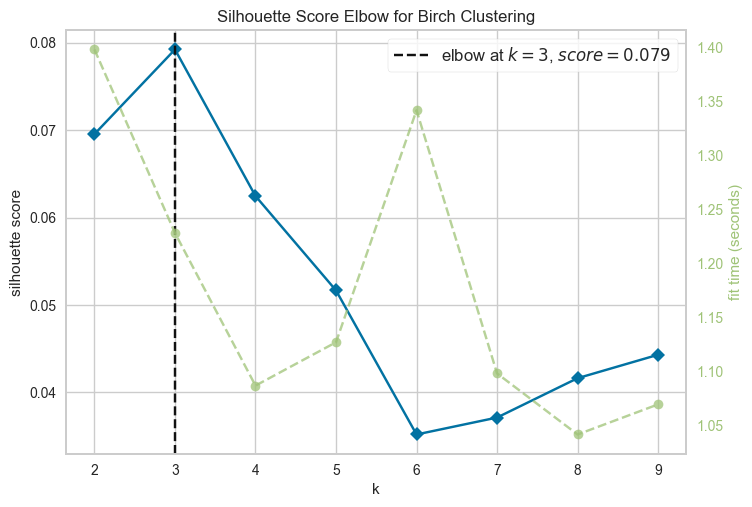

<Axes: title={'center': 'Silhouette Score Elbow for Birch Clustering'}, xlabel='k', ylabel='silhouette score'>

In [200]:
model = Birch(branching_factor=100, threshold=.5, n_clusters=None)
visualizer = KElbowVisualizer(model, k=(2,10),metric='silhouette', timings= True)
visualizer.fit(data_attitude_processed)
visualizer.show()

### BIRCH

In [236]:
brc = Birch(branching_factor=100, threshold=.5, n_clusters=6)
brc.fit(data_attitude_pca)
labels_birch = brc.predict(data_attitude_pca)

In [237]:
plot_3D(data_attitude_pca, labels_birch)

In [217]:
compute_silhouette_score(data_attitude_pca, labels_birch)

Silhouette Coefficient: 0.2133318262753328


Silhouette Coefficient: Measures how similar an object is to its own cluster compared to other clusters. Values range from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

Calinski-Harabasz Index: Also known as the Variance Ratio Criterion, this metric evaluates the cluster compactness and separation, where a higher score denotes a model with better defined clusters.

Davies-Bouldin Index: This index is defined as the average similarity measure of each cluster with its most similar cluster. Clusters which are farther apart and less dispersed will result in a lower score, which is desirable.

Dunn Index: It identifies clusters that are well-separated and compact. A higher Dunn index indicates better clustering.

#### DBSCAN

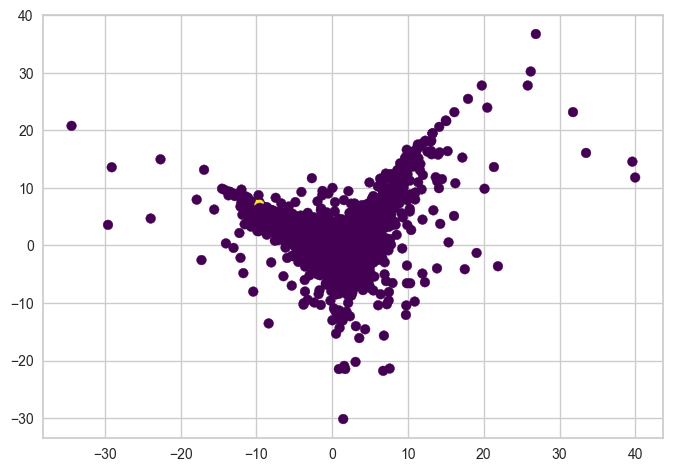

In [221]:
dbscan = DBSCAN()
dbscan.fit(data_attitude_processed)
labels_dbscan = dbscan.labels_

plt.scatter(data_attitude_pca.iloc[:,0], data_attitude_pca.iloc[:,1], c=labels_dbscan, cmap='viridis')
plt.show()

In [223]:
compute_silhouette_score(data_attitude_pca, labels_dbscan)

Silhouette Coefficient: -0.3361962397153424


### Agglomerative Clustering

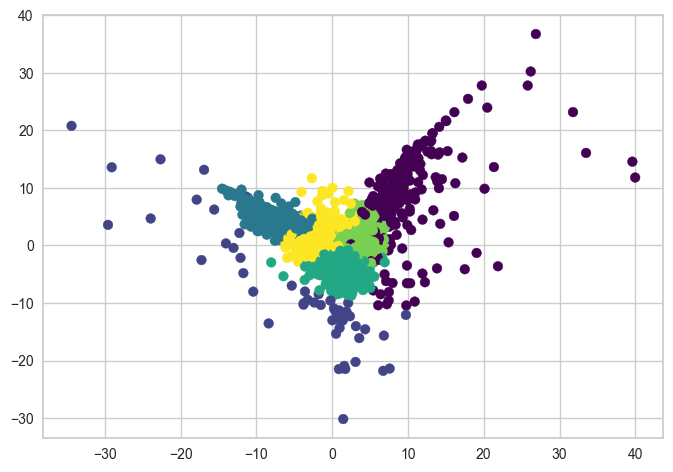

In [224]:
agglo = AgglomerativeClustering(n_clusters=6)
agglo.fit(data_attitude_pca)
labels_agglo = agglo.labels_

plt.scatter(data_attitude_pca.iloc[:,0], data_attitude_pca.iloc[:,1], c=labels_agglo, cmap='viridis')
plt.show()

In [225]:
plot_3D(data_attitude_pca, labels_agglo)

In [226]:
compute_silhouette_score(data_attitude_pca, labels_agglo)

Silhouette Coefficient: 0.2769968874335322


### KMeans

In [254]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(data_attitude_pca)
labels_kmeans_attitude = kmeans.labels_

In [255]:
plot_3D(data_attitude_pca, labels_kmeans_attitude)

In [256]:
compute_silhouette_score(data_attitude_pca, labels_kmeans_attitude)

Silhouette Coefficient: 0.3380419345182363


## Usages

In [230]:
plot_3D(data_usage_pca)

### Elbow method

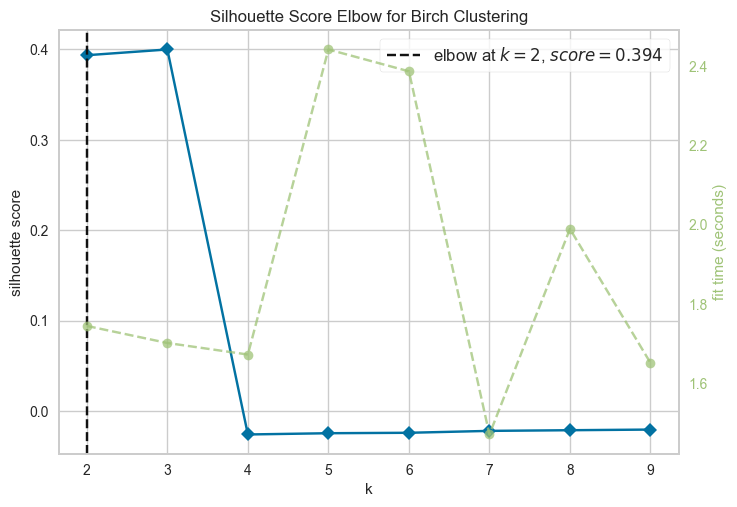

<Axes: title={'center': 'Silhouette Score Elbow for Birch Clustering'}, xlabel='k', ylabel='silhouette score'>

In [231]:
model = Birch(branching_factor=100, threshold=.5, n_clusters=None)
visualizer = KElbowVisualizer(model, k=(2,10),metric='silhouette', timings= True)
visualizer.fit(data_usage_processed)
visualizer.show()

### BIRCH

In [238]:
brc = Birch(branching_factor=100, threshold=.5, n_clusters=6)
brc.fit(data_usage_pca)
labels_birch = brc.predict(data_usage_pca)

In [239]:
plot_3D(data_usage_pca, labels_birch)

In [240]:
compute_silhouette_score(data_usage_pca, labels_birch)

Silhouette Coefficient: 0.3011637628455973


Silhouette Coefficient: Measures how similar an object is to its own cluster compared to other clusters. Values range from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

Calinski-Harabasz Index: Also known as the Variance Ratio Criterion, this metric evaluates the cluster compactness and separation, where a higher score denotes a model with better defined clusters.

Davies-Bouldin Index: This index is defined as the average similarity measure of each cluster with its most similar cluster. Clusters which are farther apart and less dispersed will result in a lower score, which is desirable.

Dunn Index: It identifies clusters that are well-separated and compact. A higher Dunn index indicates better clustering.

### DBSCAN

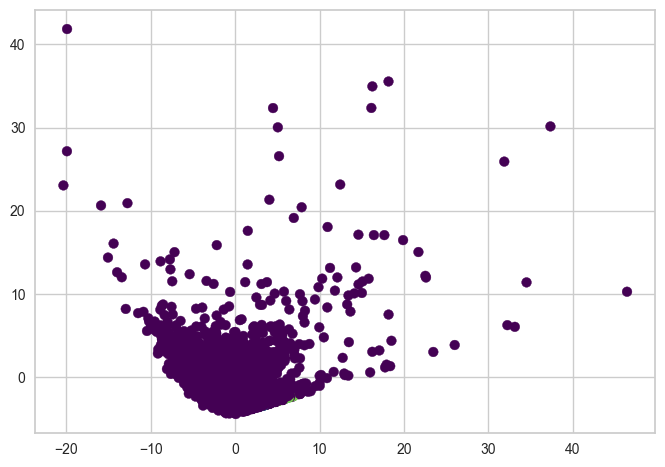

In [242]:
dbscan = DBSCAN()
dbscan.fit(data_usage_processed)
labels_dbscan = dbscan.labels_

plt.scatter(data_usage_pca.iloc[:,0], data_usage_pca.iloc[:,1], c=labels_dbscan, cmap='viridis')
plt.show()

In [243]:
compute_silhouette_score(data_usage_pca, labels_dbscan)

Silhouette Coefficient: -0.23205801044465743


### Agglomerative Clustering

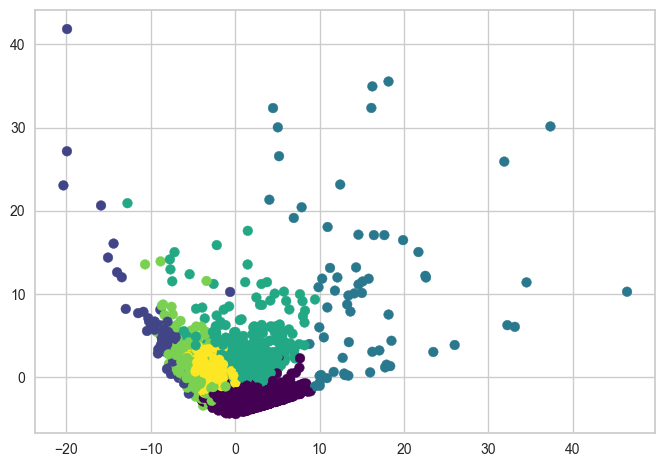

In [244]:
agglo = AgglomerativeClustering(n_clusters=6)
agglo.fit(data_usage_pca)
labels_agglo = agglo.labels_

plt.scatter(data_usage_pca.iloc[:,0], data_usage_pca.iloc[:,1], c=labels_agglo, cmap='viridis')
plt.show()

In [245]:
plot_3D(data_usage_pca, labels_agglo)

In [246]:
compute_silhouette_score(data_usage_pca, labels_agglo)

Silhouette Coefficient: 0.261537440457652


### KMeans

In [271]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(data_usage_pca)
labels_kmeans_usage = kmeans.labels_

In [272]:
plot_3D(data_attitude_pca, labels_kmeans_usage)

In [273]:
compute_silhouette_score(data_usage_pca, labels_kmeans_usage)

Silhouette Coefficient: 0.26911613259206213


# 2

Classifier (labels = clusters) et prendre feature importance = golden questions. -> XGBoost

## Attitude

In [257]:
seed = 42

model = XGBClassifier(random_state=seed, enable_categorical=False)
scores = cross_val_score(model, data_attitude_processed, labels_kmeans_attitude, cv=5, n_jobs=-1)
scores

array([0.923, 0.915, 0.9  , 0.92 , 0.915])

In [258]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.91 (+/- 0.02)


In [259]:
X_train, X_test, y_train, y_test = train_test_split(data_attitude_processed, labels_kmeans_attitude, test_size=0.2, random_state=seed)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test, predictions))

Accuracy: 92.00%
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       253
           1       1.00      0.75      0.86        28
           2       0.95      0.94      0.94       462
           3       0.97      0.86      0.92        88
           4       0.75      1.00      0.86        12
           5       0.90      0.92      0.91       157

    accuracy                           0.92      1000
   macro avg       0.91      0.90      0.90      1000
weighted avg       0.92      0.92      0.92      1000



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

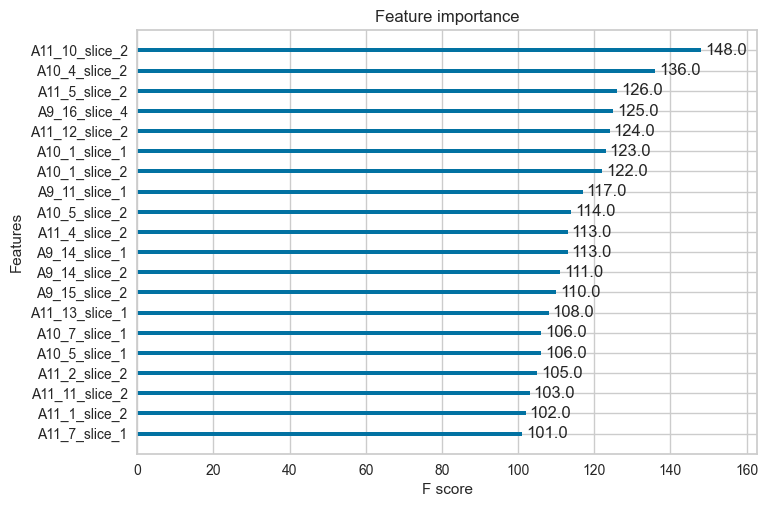

In [261]:
plot_importance(model, max_num_features=20, importance_type='weight')

In [145]:
importance = model.get_booster().get_score(importance_type="weight")
# sort by value
sorted_importance = sorted(importance.items(), key=lambda kv: kv[1], reverse=True)
sorted_importance = np.array(sorted_importance)

In [146]:
question_importance = np.vectorize(lambda x: "_".join(x.split("_")[:-1]))(sorted_importance[:, 0])
question_importance, ind = np.unique(question_importance, return_index=True)
question_importance = question_importance[np.argsort(ind)]
question_importance

array(['A11_10_slice', 'A10_4_slice', 'A11_5_slice', 'A9_16_slice',
       'A11_12_slice', 'A10_1_slice', 'A9_11_slice', 'A10_5_slice',
       'A9_14_slice', 'A11_4_slice', 'A9_15_slice', 'A11_13_slice',
       'A10_7_slice', 'A11_2_slice', 'A11_11_slice', 'A11_1_slice',
       'A11_7_slice', 'A9_7_slice', 'A10_2_slice', 'A11_6_slice',
       'A9_9_slice', 'A11_8_slice', 'A9_6_slice', 'A9_3_slice',
       'A11_3_slice', 'A9_1_slice', 'A9_12_slice', 'A9_4_slice',
       'A9_2_slice', 'A9_10_slice', 'A9_13_slice', 'A11_9_slice',
       'A9_8_slice', 'A10_6_slice', 'A10_3_slice', 'A10_8_slice',
       'A9_5_slice'], dtype='<U12')

In [262]:
def benchmark_feature_importance(importance, data, labels):
    accuracies = []
    for i in range(1, len(importance)+1):
        features = importance[:i]
        X = data.loc[:, data.columns.str.startswith(tuple(features))]
        model = XGBClassifier(random_state=seed, enable_categorical=False)
        scores = cross_val_score(model, X, labels, cv=5, n_jobs=-1)
        accuracies.append(scores.mean() * 100)
    return accuracies

In [263]:
accuracies_by_feature_count = benchmark_feature_importance(question_importance, data_attitude_processed, labels_kmeans_attitude)

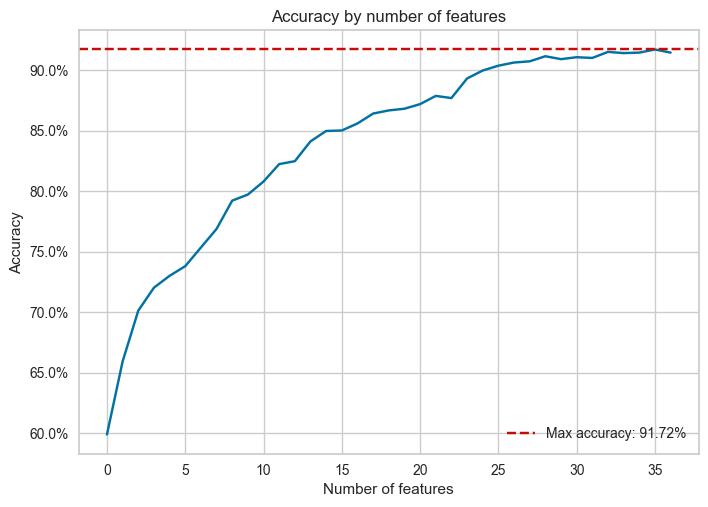

In [265]:
plt.plot(accuracies_by_feature_count)
max_accuracy = max(accuracies_by_feature_count)
plt.axhline(max_accuracy, color='r', linestyle='--', label=f"Max accuracy: {max_accuracy:.2f}%")
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.title("Accuracy by number of features")
plt.legend()
plt.show()

## Usages

# 3

Classifier avec labels (clusters) orange et features vertes, vice versa. -> XGBoost

### Compute for the green ones -> PCA of 3 + KMeans of 6

In [274]:
# PCA - Attitudes
data_attitude_socio_pca, pca_attitude_socio = apply_pca(data_attitude_socio_processed, n_components=3)

# PCA - Usage
data_usage_socio_pca, pca_usage_socio = apply_pca(data_usage_socio_processed, n_components=3)

# KMeans - Attitudes
kmeans_attitudes = KMeans(n_clusters=6, random_state=0).fit(data_attitude_socio_pca)
labels_attitudes_socio = kmeans_attitudes.labels_

# KMeans - Usage
birch_usage = Birch(branching_factor=100, threshold=.5, n_clusters=6).fit(data_usage_socio_pca)
labels_usage_socio = birch_usage.predict(data_usage_socio_pca)

### Make a XGbooost that classifies clusters from data_usage_pca into 6 classes based on the labels of data_attitude_pca

In [275]:
RANDOM_STATE = 42
TEST_SIZE = 0.4

usage_train, usage_test, labels_usage_train, labels_usage_test = train_test_split(data_usage_socio_processed, labels_usage_socio, test_size=TEST_SIZE, random_state=RANDOM_STATE)
attitudes_train, attitudes_test, labels_attitude_train, labels_attitude_test = train_test_split(data_attitude_socio_processed, labels_attitudes_socio, test_size=TEST_SIZE, random_state=RANDOM_STATE)

### Usage data trained on attitudes labels

Accuracy: 0.513


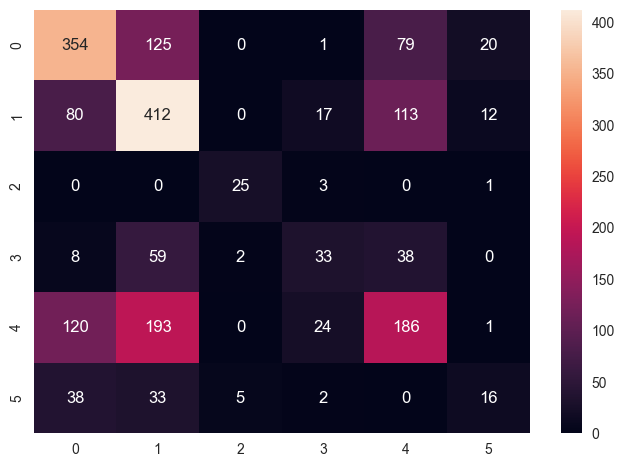

In [276]:
xgb = XGBClassifier()
xgb.fit(usage_train, labels_attitude_train)

# Predict
preds = xgb.predict(usage_test)

# Accuracy
accuracy = accuracy_score(labels_attitude_test, preds)
print(f'Accuracy: {accuracy}')

# Confusion Matrix
cm = confusion_matrix(labels_attitude_test, preds)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

### Attitudes data trained on usage labels

Accuracy: 0.8725


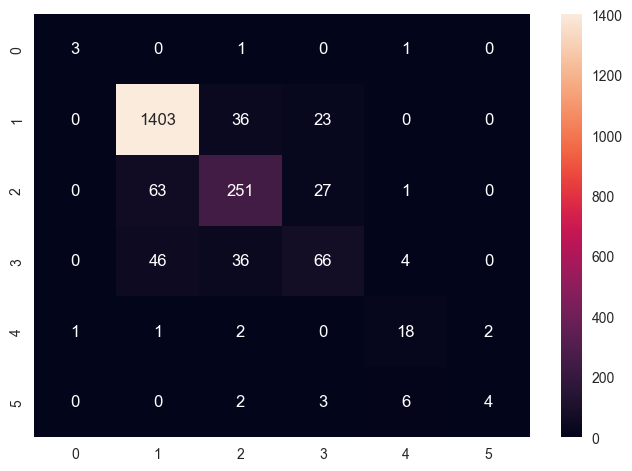

In [277]:
xgb = XGBClassifier()
xgb.fit(attitudes_train, labels_usage_train)

# Predict
preds = xgb.predict(attitudes_test)

# Accuracy
accuracy = accuracy_score(labels_usage_test, preds)
print(f'Accuracy: {accuracy}')

# Confusion Matrix
cm = confusion_matrix(labels_usage_test, preds)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()